# Synthesis Algorithms
- Split Det (sd) = translate to tgba, split, then determinize
- Det Split (ds) = translate to tgba, determinize, then split
- DPA Split (ps) = translate to dpa, then split
- LAR = translate to a deterministic automaton with arbitrar acceptance condition, then use LAR to turn to parity, then split (default)

In [137]:
from dataclasses import dataclass
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import re

# Loading Data

## Synt Tools Loading

In [138]:
@dataclass
class BenchmarkResult:
    benchmark_name: str
    tool: str
    total_durations: int # In milliseconds
    is_realizable: bool
    total_states: int
    is_completed: bool

    @staticmethod
    def read_from_hoa(hoa_filepath: str):
        hoa = Path(hoa_filepath).read_text()
        
        total_duration_rgx = "Total Duration:\s*(\d+[.]?\d*)"
        tool_name_rgx = "Tool:\s*(.*)[*]"
        total_states_rgx = "States:\s*(\d+)"
        benchmark_name = Path(hoa_filepath).stem
        
        is_completed = ("REALIZABLE" in hoa) or ("UNREALIZABLE" in hoa)
        total_duration = float(re.search(total_duration_rgx, hoa).group(1))
        tool_name = re.search(tool_name_rgx, hoa).group(1)
        
        is_realizable = not("UNREALIZABLE" in hoa) if is_completed else None
        total_states = re.search(total_states_rgx, hoa).group(1) if is_realizable else None
    
        return BenchmarkResult(
            benchmark_name, tool_name.strip(), total_duration,
            is_realizable, total_states, is_completed
        )

In [139]:
algorithms_output_path = glob("../assets/synthesis-outputs/*")
algorithms = [ Path(path).stem for path in algorithms_output_path]

In [140]:
algorithms_benchmarks = {}
for algo, outputs_path in zip(algorithms, algorithms_output_path):
    benchmarks_path = glob(f"{outputs_path}/*")
    benchmarks = [ BenchmarkResult.read_from_hoa(benchmark) for benchmark in benchmarks_path]
    algorithms_benchmarks[algo] = benchmarks

In [141]:
all_benchmarks_dict = []
for algo, benchmarks in algorithms_benchmarks.items():
    for benchmark in benchmarks:
        all_benchmarks_dict.append(benchmark.__dict__)
benchmarks_df = pd.DataFrame(all_benchmarks_dict)
benchmarks_df.head()

,benchmark_name,tool,total_durations,is_realizable,total_states,is_completed
0,TwoCountersInRangeA4,ltlsynt-ds,6892.819,False,None,True
1,ltl2dba05,ltlsynt-ds,20.461,True,5,True
2,ltl2dba11,ltlsynt-ds,23.871,True,1,True
3,TwoCountersDisButA6,ltlsynt-ds,2401558.201,None,None,False
4,TorcsSteeringSimple,ltlsynt-ds,24.025,True,1,True


In [142]:
# Removing total duration from incompleted benchmarks
benchmarks_df.loc[benchmarks_df["is_completed"] == False, "total_durations"] = None
benchmarks_df[benchmarks_df["is_completed"] == False]

,benchmark_name,tool,total_durations,is_realizable,total_states,is_completed
3,TwoCountersDisButA6,ltlsynt-ds,NaN,None,None,False
6,TwoCountersDisButA7,ltlsynt-ds,NaN,None,None,False
13,TwoCountersDisButAC,ltlsynt-ds,NaN,None,None,False
14,TwoCountersDisButA5,ltlsynt-ds,NaN,None,None,False
21,TwoCountersDisButA4,ltlsynt-ds,NaN,None,None,False
...,...,...,...,...,...,...
987,10,ltlsynt-ps,NaN,None,None,False
989,11,ltlsynt-ps,NaN,None,None,False
1016,TwoCountersDisButA9,ltlsynt-ps,NaN,None,None,False
1018,TwoCounters5,ltlsynt-ps,NaN,None,None,False


## Find Deps Loading

In [143]:
find_deps_df = pd.read_csv('../assets/find_deps_by_auto_summary.csv', index_col=0)
find_deps_df.head()

,name,total_inputs,total_outputs,is_completed,automaton_build_duration,is_automaton_built,find_deps_duration,total_dependent_vars,dependency_ratio,input_vars,output_vars,dependent_vars,independent_vars,untested_vars,total_duration
0,ltl2dpa20,3,2,True,33.0,True,2.0,1,0.500000,"['c', 'b', 'a']","['p1', 'p0']",['p0'],['p1'],[],35
1,TwoCountersInRangeA2,11,8,True,7728.0,True,7.0,3,0.375000,"['p0p0second0selected', 'p0p0in2range0f1dincre...","['u0selected0f1dtoggle0selected1b', 'u0selecte...","['u0first2counter0first2counter', 'u0second2co...",['u0first2counter0f1ddecrement0first2counter1b...,[],7735
2,lilydemo24,4,4,True,21.0,True,1.0,0,0.000000,"['r2b_ack1', 'r2b_ack0', 's2b_req1', 's2b_req0']","['b2r_req1', 'b2r_req0', 'b2s_ack1', 'b2s_ack0']",[],"['b2s_ack0', 'b2s_ack1', 'b2r_req0', 'b2r_req1']",[],22
3,OneCounterGuiA9,9,9,True,15417.0,True,11.0,3,0.333333,"['p0p0in2range0f1dinc0f1dinc0counter1b1b', 'p0...","['u0counter0f1dinc0counter1b', 'u0counter0f1dd...","['u0button2down0button2down', 'u0button2up0but...","['u0button2down0f1ddisable1b', 'u0button2down0...",[],15428
4,ltl2dba24,1,1,True,8.0,True,0.0,0,0.000000,['p'],['acc'],[],['acc'],[],8


In [144]:
find_deps_df.loc[find_deps_df["is_completed"] == False, "total_duration"] = None
find_deps_df[find_deps_df["is_completed"] == False]

,name,total_inputs,total_outputs,is_completed,automaton_build_duration,is_automaton_built,find_deps_duration,total_dependent_vars,dependency_ratio,input_vars,output_vars,dependent_vars,independent_vars,untested_vars,total_duration
13,KitchenTimerV7,4,8,False,NaN,False,NaN,0,0.0,"['p0p0eq0time0f1dzero1b', 'p0b0btn2start2stop'...","['u0time0f1dcountup0time0dt1b', 'u0time0f1dcou...",[],[],"['u0time0f1dinc2minutes0time1b', 'u0time0f1dco...",NaN
37,KitchenTimerV6,4,6,False,NaN,False,NaN,0,0.0,"['p0p0eq0time0f1dzero1b', 'p0b0btn2start2stop'...","['u0time0f1dcountup0time0dt1b', 'u0time0f1dcou...",[],[],"['u0time0f1dzero1b', 'u0time0f1dinc2minutes0ti...",NaN
67,Automata16S,2,21,False,NaN,False,NaN,0,0.0,"['p0b0wait', 'p0b0start']","['u0out0f1dnone1b', 'u0out0f1dconst91b', 'u0ou...",[],[],"['u0out0f1dconst81b', 'u0out0f1dconst24231b', ...",NaN
70,Automata32S,2,37,False,NaN,False,NaN,0,0.0,"['p0b0wait', 'p0b0start']","['u0out0f1dnone1b', 'u0out0f1dconst91b', 'u0ou...",[],[],"['u0out0f1dconst25231b', 'u0out0f1dconst25251b...",NaN
72,TwoCountersDisButAC,15,13,False,NaN,False,NaN,0,0.0,"['p0p0second0selected', 'p0p0in2range0f1dincre...","['u0window0f1denable2button0up1b', 'u0window0f...",[],[],"['u0selected0f1dtoggle0selected1b', 'u0window0...",NaN
74,TwoCountersDisButA8,14,13,False,NaN,False,NaN,0,0.0,"['p0p0second0selected', 'p0p0in2range0f1dincre...","['u0window0f1denable2button0up1b', 'u0window0f...",[],[],"['u0selected0f1dtoggle0selected1b', 'u0window0...",NaN
80,TwoCounters5,19,13,False,NaN,False,NaN,0,0.0,"['p0p0second0selected', 'p0p0in2range0f1dincre...","['u0window0f1denable2button0up1b', 'u0window0f...",[],[],"['u0selected0f1dtoggle0selected1b', 'u0window0...",NaN
82,TwoCountersDisButA9,14,13,False,NaN,False,NaN,0,0.0,"['p0p0second0selected', 'p0p0in2range0f1dincre...","['u0window0f1denable2button0up1b', 'u0window0f...",[],[],"['u0selected0f1dtoggle0selected1b', 'u0window0...",NaN
107,TwoCountersDisButA6,13,13,False,NaN,False,NaN,0,0.0,"['p0p0second0selected', 'p0p0in2range0f1dincre...","['u0window0f1denable2button0up1b', 'u0window0f...",[],[],"['u0selected0f1dtoggle0selected1b', 'u0window0...",NaN
131,Gamelogic,5,25,False,NaN,False,NaN,0,0.0,['p0p0hitenemy0f1dgetenemyangle0enemies0counte...,"['u0shot2counter0f1ddec0shot2counter1b', 'u0sh...",[],[],"['u0shot2counter0f1denemycount1b', 'u0scorecol...",NaN


# Overview Benchmarks

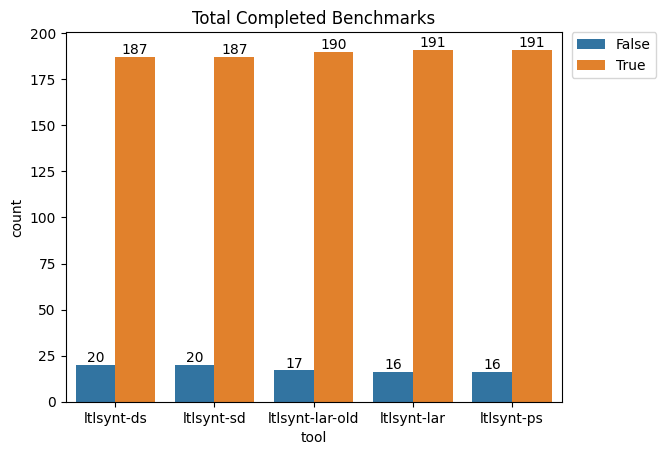

In [145]:
ax = sns.countplot(x="tool", data=benchmarks_df, hue="is_completed")
for container in ax.containers: ax.bar_label(container)
ax.set_title("Total Completed Benchmarks")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

# Comparing Tools

In [146]:
synt_tools = benchmarks_df.pivot(index='benchmark_name', columns='tool', values='total_durations').copy()
find_deps_tool = find_deps_df[["name","total_duration","total_dependent_vars","dependency_ratio"]].copy()
find_deps_tool.rename(columns={"name": "benchmark_name", "total_duration": "find-deps"}, inplace=True)

tools_comparastion_df = pd.merge(synt_tools, find_deps_tool, on="benchmark_name", how="outer")
tools_headers = ["ltlsynt-ds","ltlsynt-lar","ltlsynt-lar-old","ltlsynt-ps","ltlsynt-sd","find-deps"]
tools_comparastion_df["max"] =  tools_comparastion_df[tools_headers].idxmax(axis=1)
tools_comparastion_df["min"] =  tools_comparastion_df[tools_headers].idxmin(axis=1)
tools_comparastion_df.head()

,benchmark_name,ltlsynt-ds,ltlsynt-lar,ltlsynt-lar-old,ltlsynt-ps,ltlsynt-sd,find-deps,total_dependent_vars,dependency_ratio,max,min
0,01,54.030,27.870,33.675,46.161,30.619,68.0,0.0,0.0,find-deps,ltlsynt-lar
1,02,182.121,200.870,273.885,215.672,NaN,629.0,0.0,0.0,find-deps,ltlsynt-ds
2,03,17245.843,55888.997,60016.037,62017.015,NaN,70463.0,0.0,0.0,find-deps,ltlsynt-ds
3,05,980777.076,1568137.223,1890583.160,1945574.888,NaN,NaN,NaN,NaN,ltlsynt-ps,ltlsynt-ds
4,06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


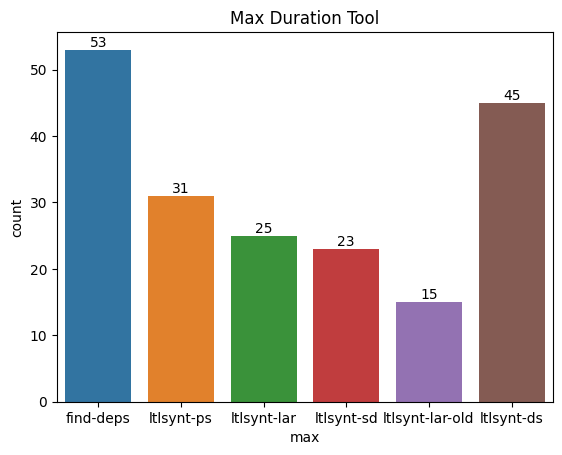

In [147]:
ax = sns.countplot(x="max", data=tools_comparastion_df)
for container in ax.containers: ax.bar_label(container)
ax.set_title("Max Duration Tool");

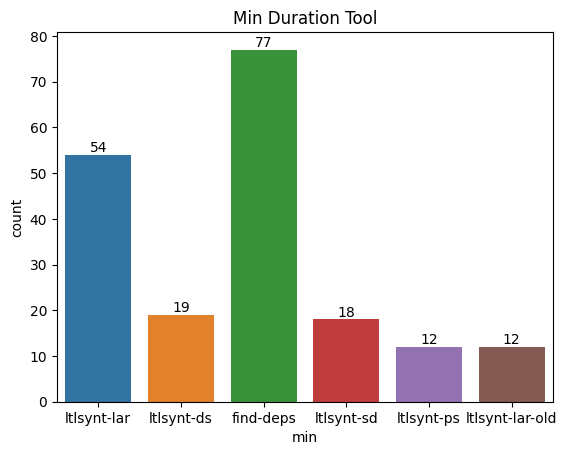

In [148]:
ax = sns.countplot(x="min", data=tools_comparastion_df)
for container in ax.containers: ax.bar_label(container)
ax.set_title("Min Duration Tool");